In [316]:
import pandas as pd
import numpy as np
from os import path
from CSVUtils import *
import ta
import matplotlib.pyplot as plt
import seaborn as sn

# Import required libraries
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

In [352]:
DIR = "./input/yahoo"
nameList = ["^GSPC", "^GDAXI", "^HSI"]
trainStartDate = pd.to_datetime("2000-01-01")
trainEndDate = pd.to_datetime("2014-12-31")
testStartDate = pd.to_datetime("2015-01-01")
testEndDate = pd.to_datetime("2019-12-31")

# for name in nameList:
df = csv2df(csv_path=DIR, csv_name=nameList[1]+".csv", source="yahoo")

In [353]:
df['Future_Price_7d'] = df.Price.shift(-7)
df['Future_Price_30d'] = df.Price.shift(-30)
df['Date'] = pd.to_datetime(df['Date'])
df.dropna(inplace=True)

df['Change_7d'] = (df['Future_Price_7d'] - df['Price'])/df['Price']
df['Change_30d'] = (df['Future_Price_30d'] - df['Price'])/df['Price']
df.fillna(0, inplace=True)

bins = [-np.inf, -0.1, -0.01, 0.01, 0.1, np.inf]
labels=['Strong Bear','Weak Bear','Horizontal','Weak Bull', 'Strong Bull']
label_lookup = {"Strong Bear": 0,  "Weak Bear": 1, 'Horizontal':2, 'Weak Bull': 3, 'Strong Bull': 4}
# label_lookup = {"Strong Bear": 0, 'Bear': 1, "Weak Bear": 2, 'Horizontal':3, 'Weak Bull': 4, 'Bull':5, 'Strong Bull': 6}

df['Cat_7d'] = pd.cut(df['Change_7d'], bins=bins, labels=labels)
df['Cat_30d'] = pd.cut(df['Change_30d'], bins=bins, labels=labels)
df["Cat_Int_7d"] = df["Cat_7d"].map(label_lookup)
df["Cat_Int_30d"] = df["Cat_30d"].map(label_lookup)

In [354]:
df = ta.add_all_ta_features(
    df, open="Open", high="High", low="Low", close="Price", volume="Vol")

c:\users\lzcai\anaconda3\envs\tensorflow2\lib\site-packages\ta\trend.py:543: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
c:\users\lzcai\anaconda3\envs\tensorflow2\lib\site-packages\ta\trend.py:547: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [355]:
future_cols = ['Future_Price_7d', 'Future_Price_30d', 'Cat_7d', 'Cat_30d', "Cat_Int_7d", "Cat_Int_30d", 'Change_7d', 'Change_30d']
target_cols = ["Cat_Int_7d", "Cat_Int_30d", 'Future_Price_7d', 'Future_Price_30d']
data_cols = [col for col in list(df.columns) if col not in future_cols]
df[data_cols] = df[data_cols].fillna(0)
data_cols.remove('Date')

In [356]:
df_backup = df.copy()
# df[data_cols] = df[data_cols]/df[data_cols].max()
df[data_cols] = df[data_cols].replace([np.inf, -np.inf], np.nan)
df[data_cols] = df[data_cols].fillna(0)

In [358]:
train_df = df[(df['Date'] >= trainStartDate) & (df['Date'] <= trainEndDate)]
test_df = df[(df['Date'] >= testStartDate) & (df['Date'] <= testEndDate)]

In [359]:
X_train = train_df[data_cols].values
y_train = train_df[target_cols[0]].values

X_test = test_df[data_cols].values
y_test = test_df[target_cols[0]].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)

mlp = MLPClassifier(hidden_layer_sizes=(32,32,16), activation='relu', solver='adam', max_iter=5000)
# mlp = MLPRegressor(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)

mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_train,predict_train))
print('\n\n')
print(classification_report(y_train,predict_train))

(3736, 73)
(1252, 73)
[[   0    0    0   63    0]
 [   0    4    0 1158    0]
 [   0    0    5  901    0]
 [   0    0    0 1581    0]
 [   0    0    0   24    0]]



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       1.00      0.00      0.01      1162
           2       1.00      0.01      0.01       906
           3       0.42      1.00      0.60      1581
           4       0.00      0.00      0.00        24

    accuracy                           0.43      3736
   macro avg       0.48      0.20      0.12      3736
weighted avg       0.73      0.43      0.26      3736



c:\users\lzcai\anaconda3\envs\tensorflow2\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [336]:
X_train = train_df[data_cols].values
y_train = train_df[target_cols[2]].values

X_test = test_df[data_cols].values
y_test = test_df[target_cols[2]].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)

# mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
mlp = MLPRegressor(hidden_layer_sizes=(32,32,16), activation='relu', solver='adam', max_iter=5000)

mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

print(np.sqrt(mean_squared_error(y_train,predict_train)))
print(np.sqrt(mean_squared_error(y_test,predict_test))) 

(3773, 73)
(1258, 73)
382480.88415420114
360550.01630469563


In [298]:
X_train = train_df[data_cols].values
y_train = train_df[target_cols[1]].values

X_test = test_df[data_cols].values
y_test = test_df[target_cols[1]].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)

mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=5000)
# mlp = MLPRegressor(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)

mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_train,predict_train))
print('\n\n')
print(classification_report(y_train,predict_train))

(3773, 73)
(1258, 73)
[[   4    0    0    0  179    0    0]
 [   0    0    0    0  721    0    0]
 [   0    0    0    0  339    0    0]
 [   0    0    0    0  590    0    0]
 [   0    0    0    0 1296    0    0]
 [   0    0    0    0  550    0    0]
 [   0    0    0    0   93    0    1]]



              precision    recall  f1-score   support

           0       1.00      0.02      0.04       183
           1       0.00      0.00      0.00       721
           2       0.00      0.00      0.00       339
           3       0.00      0.00      0.00       590
           4       0.34      1.00      0.51      1296
           5       0.00      0.00      0.00       550
           6       1.00      0.01      0.02        94

    accuracy                           0.34      3773
   macro avg       0.33      0.15      0.08      3773
weighted avg       0.19      0.34      0.18      3773



c:\users\lzcai\anaconda3\envs\tensorflow2\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [299]:
X_train = train_df[data_cols].values
y_train = train_df[target_cols[2]].values

X_test = test_df[data_cols].values
y_test = test_df[target_cols[2]].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)

# mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
mlp = MLPRegressor(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=5000)

mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

print(np.sqrt(mean_squared_error(y_train,predict_train)))
print(np.sqrt(mean_squared_error(y_test,predict_test))) 

(3773, 73)
(1258, 73)
16804708.14010736
6584818.296316989


In [300]:
from sklearn.linear_model import LinearRegression

X_train = train_df[data_cols].values
y_train = train_df[target_cols[2]].values

X_test = test_df[data_cols].values
y_test = test_df[target_cols[2]].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)

# mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
reg = LinearRegression()

reg.fit(X_train,y_train)

predict_train = reg.predict(X_train)
predict_test = reg.predict(X_test)

print(np.sqrt(mean_squared_error(y_train,predict_train)))
print(np.sqrt(mean_squared_error(y_test,predict_test))) 

(3773, 73)
(1258, 73)
32.7643007203198
76.74459187331946


In [301]:
result_df = pd.DataFrame({'Name':train_df[data_cols].columns, 'Value': reg.coef_})

In [302]:
result_df['Abs'] = np.absolute(result_df['Value'])

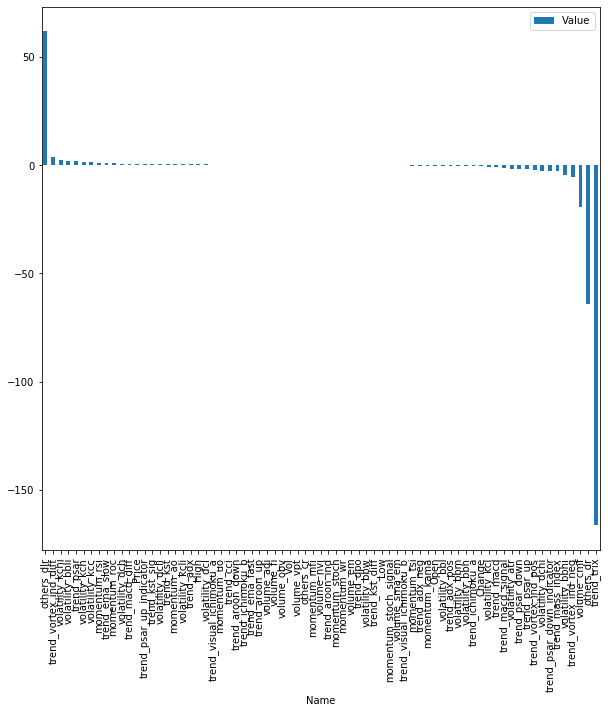

In [303]:
result_df.sort_values('Value', ascending=False).plot(figsize = (10,10), kind='bar',x='Name',y='Value')

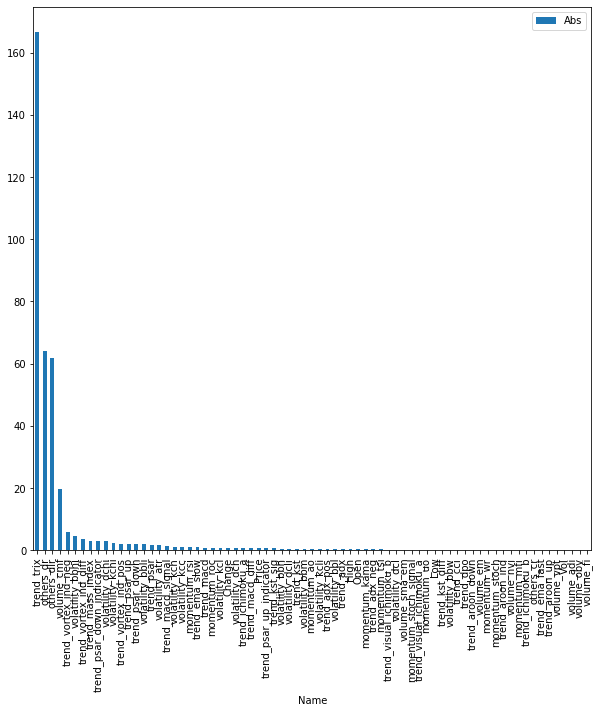

In [304]:
result_df.sort_values('Abs', ascending=False).plot(figsize = (10,10), kind='bar',x='Name',y='Abs')

In [307]:
result_df[result_df['Abs']>=10].sort_values('Value', ascending=False)

,Name,Value,Abs
71,others_dlr,61.708474,61.708474
8,volume_cmf,-19.548644,19.548644
70,others_dr,-64.179721,64.179721
41,trend_trix,-166.473355,166.473355


In [308]:
df_backup['trend_trix']

1       0.000000
2       0.000000
3       0.000000
4       0.000000
5       0.000000
          ...   
7600    0.154626
7601    0.155834
7602    0.156392
7603    0.155611
7604    0.154644
Name: trend_trix, Length: 7604, dtype: float64

In [315]:
df['trend_trix']

1       0.000000
2       0.000000
3       0.000000
4       0.000000
5       0.000000
          ...   
7600    0.154626
7601    0.155834
7602    0.156392
7603    0.155611
7604    0.154644
Name: trend_trix, Length: 7604, dtype: float64